https://docs.opencv.org/trunk/d9/d61/tutorial_py_morphological_ops.html

#### Imports

In [2]:
from time import gmtime, strftime

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# ---- My utils ----
from models import *
from utils.train_arguments import *
from utils.utils_data import *
from utils.utils_training import *
from utils.data_augmentation import get_augmentations
import cv2
import imutils

# Longitudinales

#### Data load

In [3]:
data_augmentation = True
pretrained = False
img_size, crop_size = 512, 512
segmentation_problem= True
batch_size = 2

train_aug, val_aug, train_albumentation, val_albumentation = get_augmentations(
    data_augmentation, args.pretrained, img_size, crop_size, segmentation_problem
)

In [4]:
selected_class="Grietas longitudinales"

val_dataset = SIMEPU_Dataset(data_partition='validation', transform=val_aug,
                             validation_size=args.validation_size, binary_problem=False,
                             damaged_problem=False, segmentation_problem=True,
                             augmentation=val_albumentation, selected_class=selected_class)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, pin_memory=True,
    shuffle=False, collate_fn=val_dataset.segmentation_collate
)

#### Model Load

In [5]:
num_classes = 1
model_name = "unet_extra_small"
pretrained = False
model = model_selector(model_name, num_classes=num_classes, pretrained=pretrained)
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))

In [6]:
model.load_state_dict(torch.load("unet_extra_small_longitudinales.pt"))

<All keys matched successfully>

#### Check metric

In [7]:
binary_problem = False
segmentation_problem = True
masks_overlays = False
learning_rate = 0.01
epoch = 0

criterion = nn.BCEWithLogitsLoss()

current_val_loss, current_val_metric = val_step(
    val_loader, model, criterion, binary_problem, segmentation_problem,
    selected_class=selected_class, masks_overlays=masks_overlays, epoch=(epoch+1), lr=learning_rate
)


print(f"IOU: {current_val_metric}")

IOU: 0.673600197791265


#### Inference and measure

In [8]:
for batch_idx, (inputs, _, masks, original_imgs, original_masks, inputs_names) in enumerate(val_loader):
    inputs, masks = inputs.cuda(), masks.cuda()
    outputs = model(inputs)
    #loss = criterion(outputs, masks)
    break

In [9]:
for indx, single_pred in enumerate(outputs):
    original_mask = original_masks[indx]
    original_h, original_w = original_mask.shape
    resize_transform = albumentations.Resize(original_h, original_w)
    pred_mask = resize_transform(image=torch.sigmoid(single_pred).squeeze(0).data.cpu().numpy())["image"]
    binary_ground_truth = np.where(original_mask > 0.5, 1, 0).astype(np.int32)
    binary_pred_mask = np.where(pred_mask > 0.5, 1, 0).astype(np.int32)
    break

Text(0.5, 1.0, 'Overlay Predicho')

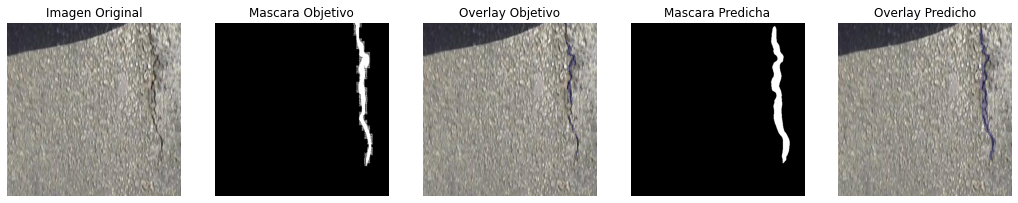

In [10]:
# def save_overlays(img, mask, predicted_mask, save_path="", display=False)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(18, 5))
ax1.axis('off'); ax2.axis('off'); ax3.axis('off'); ax4.axis('off'); ax5.axis('off')
ax1.imshow(original_imgs[indx])  # Imagen normal
ax1.set_title("Imagen Original")
ax2.imshow(binary_ground_truth, cmap="gray")  # Mascara original
ax2.set_title("Mascara Objetivo")

masked = np.ma.masked_where(binary_ground_truth == 0, binary_ground_truth)  # Overlay mascara original
ax3.imshow(original_imgs[indx], cmap="gray")
ax3.imshow(masked, 'jet', interpolation='bilinear', alpha=0.25)
ax3.set_title("Overlay Objetivo")

ax4.imshow(binary_pred_mask, cmap="gray")  # Mascara predecida
ax4.set_title("Mascara Predicha")

masked = np.ma.masked_where(binary_pred_mask == 0, binary_pred_mask)  # Overlay mascara predecida
ax5.imshow(original_imgs[indx], cmap="gray")
ax5.imshow(masked, 'jet', interpolation='bilinear', alpha=0.25)
ax5.set_title("Overlay Predicho")

In [10]:
kernel = np.ones((4,4),np.uint8)
erosion = cv2.erode(np.uint8(binary_pred_mask), kernel, iterations = 1)

In [11]:
mask = erosion > 0  # or `x != 255` where x is your array

columns_indices = np.where(np.any(mask, axis=0))[0]
rows_indices = np.where(np.any(mask, axis=1))[0]

first_column_index, last_column_index = columns_indices[0], columns_indices[-1]
first_row_index, last_row_index = rows_indices[0], rows_indices[-1]

longitud = abs(first_row_index-last_row_index)
anchura = abs(first_column_index-last_column_index)

print(f"La grieta tiene una longitud de {longitud} pixeles y {anchura} pixeles de ancho")

La grieta tiene una longitud de 396 pixeles y 50 pixeles de ancho


# Transversales

#### Data load

In [12]:
data_augmentation = True
pretrained = False
img_size, crop_size = 512, 512
segmentation_problem= True
batch_size = 2

train_aug, val_aug, train_albumentation, val_albumentation = get_augmentations(
    data_augmentation, args.pretrained, img_size, crop_size, segmentation_problem
)

In [13]:
selected_class="Grietas transversales"

val_dataset = SIMEPU_Dataset(data_partition='validation', transform=val_aug,
                             validation_size=args.validation_size, binary_problem=False,
                             damaged_problem=False, segmentation_problem=True,
                             augmentation=val_albumentation, selected_class=selected_class)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, pin_memory=True,
    shuffle=False, collate_fn=val_dataset.segmentation_collate
)

#### Model Load

In [14]:
num_classes = 1
model_name = "unet_extra_small"
pretrained = False
model = model_selector(model_name, num_classes=num_classes, pretrained=pretrained)
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))

In [15]:
model.load_state_dict(torch.load("unet_extra_small_longitudinales.pt"))

<All keys matched successfully>

#### Check metric (without rotate)

In [16]:
binary_problem = False
segmentation_problem = True
masks_overlays = False
learning_rate = 0.01
epoch = 0

criterion = nn.BCEWithLogitsLoss()

current_val_loss, current_val_metric = val_step(
    val_loader, model, criterion, binary_problem, segmentation_problem,
    selected_class=selected_class, masks_overlays=masks_overlays, epoch=(epoch+1), lr=learning_rate
)


print(f"IOU: {current_val_metric}")

IOU: 0.049336697050989864


#### Check metric (rotating)

In [17]:
val_loss, val_iou, generated_masks, = 0, [], 0
with torch.no_grad():
    for batch_idx, (inputs, _, masks, original_imgs, original_masks, inputs_names) in enumerate(val_loader):
        inputs, masks = inputs.cuda(), masks.cuda()
        outputs = model(inputs.transpose(2,3))
        loss = criterion(outputs, masks)

        val_loss += loss.item()

        for indx, single_pred in enumerate(outputs):
            original_mask = original_masks[indx]
            original_h, original_w = original_mask.shape
            resize_transform = albumentations.Resize(original_h, original_w)
            pred_mask = resize_transform(image=torch.sigmoid(single_pred.transpose(1,2)).squeeze(0).data.cpu().numpy())["image"]
            binary_ground_truth = np.where(original_mask > 0.5, 1, 0).astype(np.int32)
            binary_pred_mask = np.where(pred_mask > 0.5, 1, 0).astype(np.int32)

            tmp_iou = jaccard_coef(binary_ground_truth, binary_pred_mask)
            val_iou.append(tmp_iou)

            if generated_masks < masks_overlays:
                save_overlays(
                    original_imgs[indx],
                    binary_ground_truth, binary_pred_mask,
                    os.path.join(
                        overlays_path, selected_class, f"{lr}", f"epoch{epoch}", f"{inputs_names[indx].split('/')[-1]}"
                    )
                )
                generated_masks += 1

    val_loss = (val_loss / (batch_idx + 1))

In [18]:
print(f"IOU: {np.array(val_iou).mean()}")

IOU: 0.6288338030639202


#### Inference and measure

In [19]:
for batch_idx, (inputs, _, masks, original_imgs, original_masks, inputs_names) in enumerate(val_loader):
    inputs, masks = inputs.cuda(), masks.cuda()
    outputs = model(inputs.transpose(2,3))
    #loss = criterion(outputs, masks)
    break

In [20]:
for indx, single_pred in enumerate(outputs):
    original_mask = original_masks[indx]
    original_h, original_w = original_mask.shape
    resize_transform = albumentations.Resize(original_h, original_w)
    pred_mask = resize_transform(image=torch.sigmoid(single_pred.transpose(1,2)).squeeze(0).data.cpu().numpy())["image"]
    binary_ground_truth = np.where(original_mask > 0.5, 1, 0).astype(np.int32)
    binary_pred_mask = np.where(pred_mask > 0.5, 1, 0).astype(np.int32)
    break

Text(0.5, 1.0, 'Overlay Predicho')

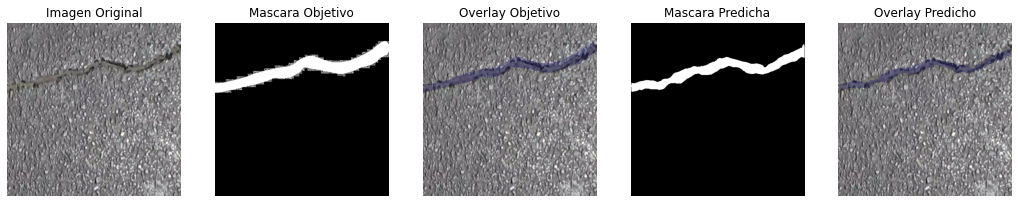

In [21]:
# def save_overlays(img, mask, predicted_mask, save_path="", display=False)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(18, 5))
ax1.axis('off'); ax2.axis('off'); ax3.axis('off'); ax4.axis('off'); ax5.axis('off')
ax1.imshow(original_imgs[indx])  # Imagen normal
ax1.set_title("Imagen Original")
ax2.imshow(binary_ground_truth, cmap="gray")  # Mascara original
ax2.set_title("Mascara Objetivo")

masked = np.ma.masked_where(binary_ground_truth == 0, binary_ground_truth)  # Overlay mascara original
ax3.imshow(original_imgs[indx], cmap="gray")
ax3.imshow(masked, 'jet', interpolation='bilinear', alpha=0.25)
ax3.set_title("Overlay Objetivo")

ax4.imshow(binary_pred_mask, cmap="gray")  # Mascara predecida
ax4.set_title("Mascara Predicha")

masked = np.ma.masked_where(binary_pred_mask == 0, binary_pred_mask)  # Overlay mascara predecida
ax5.imshow(original_imgs[indx], cmap="gray")
ax5.imshow(masked, 'jet', interpolation='bilinear', alpha=0.25)
ax5.set_title("Overlay Predicho")

In [22]:
kernel = np.ones((4,4),np.uint8)
erosion = cv2.erode(np.uint8(binary_pred_mask), kernel, iterations = 1)

In [23]:
mask = erosion > 0  # or `x != 255` where x is your array

columns_indices = np.where(np.any(mask, axis=0))[0]
rows_indices = np.where(np.any(mask, axis=1))[0]

first_column_index, last_column_index = columns_indices[0], columns_indices[-1]
first_row_index, last_row_index = rows_indices[0], rows_indices[-1]

anchura = abs(first_row_index-last_row_index)
longitud = abs(first_column_index-last_column_index)

print(f"La grieta tiene una longitud de {longitud} pixeles y {anchura} pixeles de ancho")

La grieta tiene una longitud de 509 pixeles y 134 pixeles de ancho


# Huecos

# Huecos

#### Data load

In [24]:
data_augmentation = True
pretrained = False
img_size, crop_size = 512, 512
segmentation_problem= True
batch_size = 6

train_aug, val_aug, train_albumentation, val_albumentation = get_augmentations(
    data_augmentation, args.pretrained, img_size, crop_size, segmentation_problem
)
selected_class="Huecos"

val_dataset = SIMEPU_Dataset(data_partition='validation', transform=val_aug,
                             validation_size=args.validation_size, binary_problem=False,
                             damaged_problem=False, segmentation_problem=True,
                             augmentation=val_albumentation, selected_class=selected_class)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, pin_memory=True,
    shuffle=False, collate_fn=val_dataset.segmentation_collate
)

#### Model Load

In [25]:
num_classes = 1
model_name = "unet_extra_small"
pretrained = False
model = model_selector(model_name, num_classes=num_classes, pretrained=pretrained)
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
model.load_state_dict(torch.load("unet_extra_small_huecos.pt"))

<All keys matched successfully>

#### Check metric

In [26]:
binary_problem = False
segmentation_problem = True
masks_overlays = False
learning_rate = 0.01
epoch = 0

criterion = nn.BCEWithLogitsLoss()

current_val_loss, current_val_metric = val_step(
    val_loader, model, criterion, binary_problem, segmentation_problem,
    selected_class=selected_class, masks_overlays=masks_overlays, epoch=(epoch+1), lr=learning_rate
)


print(f"IOU: {current_val_metric}")

IOU: 0.6760569975453973


#### Inference and measure

In [27]:
for batch_idx, (inputs, _, masks, original_imgs, original_masks, inputs_names) in enumerate(val_loader):
    inputs, masks = inputs.cuda(), masks.cuda()
    outputs = model(inputs)
    #loss = criterion(outputs, masks)
    break

In [28]:
for indx, single_pred in enumerate(outputs):
    original_mask = original_masks[indx]
    original_h, original_w = original_mask.shape
    resize_transform = albumentations.Resize(original_h, original_w)
    pred_mask = resize_transform(image=torch.sigmoid(single_pred).squeeze(0).data.cpu().numpy())["image"]
    binary_ground_truth = np.where(original_mask > 0.5, 1, 0).astype(np.int32)
    binary_pred_mask = np.where(pred_mask > 0.5, 1, 0).astype(np.int32)
    break

Text(0.5, 1.0, 'Overlay Predicho')

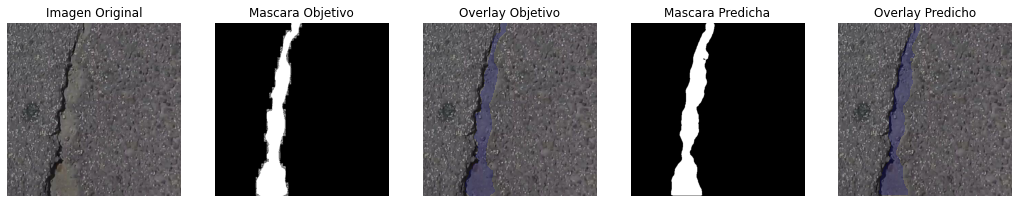

In [29]:
# def save_overlays(img, mask, predicted_mask, save_path="", display=False)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(18, 5))
ax1.axis('off'); ax2.axis('off'); ax3.axis('off'); ax4.axis('off'); ax5.axis('off')
ax1.imshow(original_imgs[indx])  # Imagen normal
ax1.set_title("Imagen Original")
ax2.imshow(binary_ground_truth, cmap="gray")  # Mascara original
ax2.set_title("Mascara Objetivo")

masked = np.ma.masked_where(binary_ground_truth == 0, binary_ground_truth)  # Overlay mascara original
ax3.imshow(original_imgs[indx], cmap="gray")
ax3.imshow(masked, 'jet', interpolation='bilinear', alpha=0.25)
ax3.set_title("Overlay Objetivo")

ax4.imshow(binary_pred_mask, cmap="gray")  # Mascara predecida
ax4.set_title("Mascara Predicha")

masked = np.ma.masked_where(binary_pred_mask == 0, binary_pred_mask)  # Overlay mascara predecida
ax5.imshow(original_imgs[indx], cmap="gray")
ax5.imshow(masked, 'jet', interpolation='bilinear', alpha=0.25)
ax5.set_title("Overlay Predicho")

In [30]:
kernel = np.ones((4,4),np.uint8)
erosion = cv2.erode(np.uint8(binary_pred_mask), kernel, iterations = 1)

In [31]:
pixeles_hueco = erosion.sum()
porcentaje_hueco = (pixeles_hueco / (binary_pred_mask.shape[0] * binary_pred_mask.shape[1]))*100

print(f"El hueco esta compuesto por {pixeles_hueco} pixeles, el {porcentaje_hueco:.2f}% de la imagen")

El hueco esta compuesto por 21530 pixeles, el 8.21% de la imagen


# Parcheo

#### Data load

In [32]:
data_augmentation = True
pretrained = False
img_size, crop_size = 512, 512
segmentation_problem= True
batch_size = 2

train_aug, val_aug, train_albumentation, val_albumentation = get_augmentations(
    data_augmentation, args.pretrained, img_size, crop_size, segmentation_problem
)
selected_class="Parcheo"

val_dataset = SIMEPU_Dataset(data_partition='validation', transform=val_aug,
                             validation_size=args.validation_size, binary_problem=False,
                             damaged_problem=False, segmentation_problem=True,
                             augmentation=val_albumentation, selected_class=selected_class)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, pin_memory=True,
    shuffle=False, collate_fn=val_dataset.segmentation_collate
)

#### Model Load

In [33]:
num_classes = 1
model_name = "unet_extra_small"
pretrained = False
model = model_selector(model_name, num_classes=num_classes, pretrained=pretrained)
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
model.load_state_dict(torch.load("unet_extra_small_parcheo.pt"))

<All keys matched successfully>

#### Check metric

In [34]:
binary_problem = False
segmentation_problem = True
masks_overlays = False
learning_rate = 0.01
epoch = 0

criterion = nn.BCEWithLogitsLoss()

current_val_loss, current_val_metric = val_step(
    val_loader, model, criterion, binary_problem, segmentation_problem,
    selected_class=selected_class, masks_overlays=masks_overlays, epoch=(epoch+1), lr=learning_rate
)

print(f"IOU: {current_val_metric}")

IOU: 0.836052561928982


#### Inference and measure

In [35]:
for batch_idx, (inputs, _, masks, original_imgs, original_masks, inputs_names) in enumerate(val_loader):
    inputs, masks = inputs.cuda(), masks.cuda()
    outputs = model(inputs)
    #loss = criterion(outputs, masks)
    break

In [36]:
for indx, single_pred in enumerate(outputs):
    original_mask = original_masks[indx]
    original_h, original_w = original_mask.shape
    resize_transform = albumentations.Resize(original_h, original_w)
    pred_mask = resize_transform(image=torch.sigmoid(single_pred).squeeze(0).data.cpu().numpy())["image"]
    binary_ground_truth = np.where(original_mask > 0.5, 1, 0).astype(np.int32)
    binary_pred_mask = np.where(pred_mask > 0.5, 1, 0).astype(np.int32)
    break

Text(0.5, 1.0, 'Overlay Predicho')

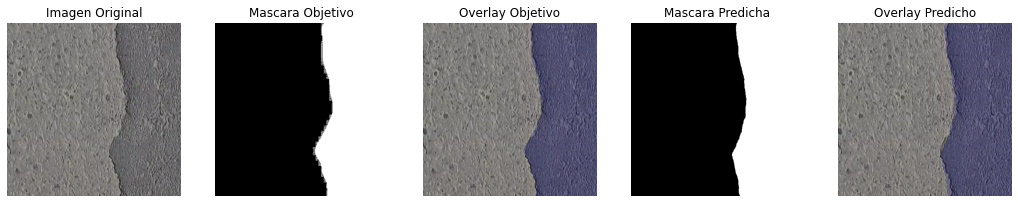

In [37]:
# def save_overlays(img, mask, predicted_mask, save_path="", display=False)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(18, 5))
ax1.axis('off'); ax2.axis('off'); ax3.axis('off'); ax4.axis('off'); ax5.axis('off')
ax1.imshow(original_imgs[indx])  # Imagen normal
ax1.set_title("Imagen Original")
ax2.imshow(binary_ground_truth, cmap="gray")  # Mascara original
ax2.set_title("Mascara Objetivo")

masked = np.ma.masked_where(binary_ground_truth == 0, binary_ground_truth)  # Overlay mascara original
ax3.imshow(original_imgs[indx], cmap="gray")
ax3.imshow(masked, 'jet', interpolation='bilinear', alpha=0.25)
ax3.set_title("Overlay Objetivo")

ax4.imshow(binary_pred_mask, cmap="gray")  # Mascara predecida
ax4.set_title("Mascara Predicha")

masked = np.ma.masked_where(binary_pred_mask == 0, binary_pred_mask)  # Overlay mascara predecida
ax5.imshow(original_imgs[indx], cmap="gray")
ax5.imshow(masked, 'jet', interpolation='bilinear', alpha=0.25)
ax5.set_title("Overlay Predicho")

In [38]:
kernel = np.ones((4,4),np.uint8)
erosion = cv2.erode(np.uint8(binary_pred_mask), kernel, iterations = 1)

In [39]:
pixeles_parcheo = erosion.sum()
porcentaje_parcheo = (pixeles_parcheo / (binary_pred_mask.shape[0] * binary_pred_mask.shape[1]))*100

print(f"El parcheo esta compuesto por {pixeles_parcheo} pixeles, el {porcentaje_parcheo:.2f}% de la imagen")

El parcheo esta compuesto por 96994 pixeles, el 37.00% de la imagen


# Piel Cocodrilo

#### Data load

In [40]:
data_augmentation = True
pretrained = False
img_size, crop_size = 512, 512
segmentation_problem= True
batch_size = 2

train_aug, val_aug, train_albumentation, val_albumentation = get_augmentations(
    data_augmentation, args.pretrained, img_size, crop_size, segmentation_problem
)
selected_class="Grietas en forma de piel de cocodrilo"

val_dataset = SIMEPU_Dataset(data_partition='segmentation_test', transform=val_aug,
                             validation_size=args.validation_size, binary_problem=False,
                             damaged_problem=False, segmentation_problem=True,
                             augmentation=val_albumentation, selected_class=selected_class)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, pin_memory=True,
    shuffle=False,# collate_fn=val_dataset.segmentation_collate
)

#### Model Load

In [41]:
num_classes = 1
model_name = "unet_extra_small"
pretrained = False
model = model_selector(model_name, num_classes=num_classes, pretrained=pretrained)
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
model.load_state_dict(torch.load("unet_extra_small_longitudinales.pt"))

<All keys matched successfully>

#### Inference and measure

In [42]:
for batch_idx, (inputs, _,original_imgs,_) in enumerate(val_loader):
    inputs = inputs.cuda()
    outputs = model(inputs)
    outputs_flipp = model(inputs.transpose(2,3))
    #loss = criterion(outputs, masks)
    break

In [43]:
for indx, single_pred in enumerate(outputs):
    original_img = original_imgs[indx]
    original_h, original_w, original_c = original_img.shape
    resize_transform = albumentations.Resize(original_h, original_w)
    
    pred_mask = resize_transform(image=torch.sigmoid(single_pred).squeeze(0).data.cpu().numpy())["image"]
    binary_pred_mask = np.where(pred_mask > 0.5, 1, 0).astype(np.int32)
    
    pred_mask_flipp = resize_transform(image=torch.sigmoid(outputs_flipp.transpose(2,3)[indx]).squeeze(0).data.cpu().numpy())["image"]
    binary_pred_mask_flipp = np.where(pred_mask_flipp > 0.5, 1, 0).astype(np.int32)
    break

Text(0.5, 1.0, 'Overlay Predicho')

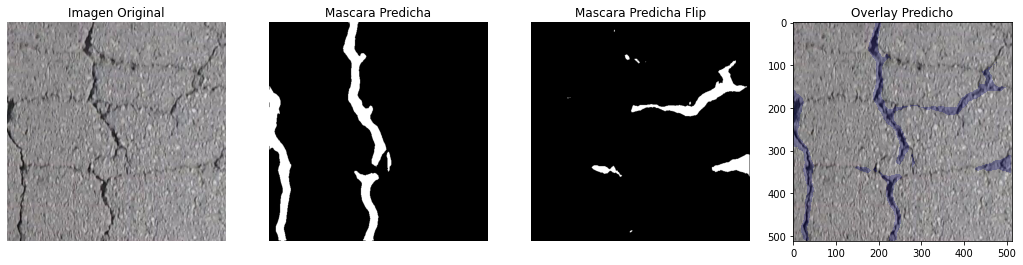

In [44]:
# def save_overlays(img, mask, predicted_mask, save_path="", display=False)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 5))
ax1.axis('off'); ax2.axis('off'); ax3.axis('off')
ax1.imshow(original_imgs[indx])  # Imagen normal
ax1.set_title("Imagen Original")

ax2.imshow(binary_pred_mask, cmap="gray")  # Mascara predecida
ax2.set_title("Mascara Predicha")

ax3.imshow(binary_pred_mask_flipp, cmap="gray")  # Mascara predecida flip
ax3.set_title("Mascara Predicha Flip")

final_mask = np.logical_or(binary_pred_mask, binary_pred_mask_flipp)*1
masked = np.ma.masked_where(final_mask == 0, final_mask)  # Overlay mascara predecida
ax4.imshow(original_imgs[indx], cmap="gray")
ax4.imshow(masked, 'jet', interpolation='bilinear', alpha=0.25)
ax4.set_title("Overlay Predicho")

In [45]:
kernel = np.ones((4,4),np.uint8)
erosion = cv2.erode(np.uint8(final_mask), kernel, iterations = 1)

In [46]:
pixeles_cocodrilo = erosion.sum()
porcentaje_parcheo = (pixeles_cocodrilo / (final_mask.shape[0] * final_mask.shape[1]))*100

print(f"El cocodrilo esta compuesto por {pixeles_parcheo} pixeles, el {porcentaje_parcheo:.2f}% de la imagen")

El cocodrilo esta compuesto por 96994 pixeles, el 8.65% de la imagen
